# Harris角点检测
光拿到边缘的信息还不够，如果想要拼合图像等操作，则必须要将图中更有信息的点给提取出来。
特征点：
    1. 可重复性。
    2. 有意义。
    3. 提取高效。
    4. 局部区域。
角点：图像中二维或者三维的交点。
![title](https://img-blog.csdn.net/20131123223210125)
计算Harris角点矩阵：
![title](https://img-blog.csdn.net/20131123223426734)
通过泰勒展开简化Harris矩阵公式：
![title](https://img-blog.csdn.net/20131123223447015)
M为实对称矩阵，需要通过R正交矩阵来将其转换为对角线矩阵。之后，通过经验公式计算Harris角点响应值：
![title](https://img-blog.csdn.net/20131123223742640)，其中k为0.04-0.06之间。
## 步骤
1. 计算x和y方向梯度
   梯度算子：sobel算子。
2. 计算二阶矩矩阵的特征值
   根据之前计算出来的x和y方向梯度，计算二阶矩矩阵，之后计算特征值。
3. 计算R值
   通过特征值计算R值。
4. 非极大值抑制
   根据之前计算的R值，在九宫格内进行非极大值抑制，并进行门限值过滤。
5. 展现
   将角点表现在原图上。

In [1]:
from cv import conv_img
import numpy as np
import matplotlib.pyplot as plt

(423, 474, 3)


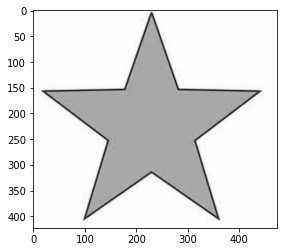

In [2]:
img = plt.imread('./star.jpg')
img = np.array(img)
print(img.shape)
a, b, c = img.shape
new_img = np.zeros(shape=(a, b))
for i in range(a):
    for j in range(b):
        new_img[i, j] = img[i, j].mean()
plt.imshow(new_img, cmap="gray")

In [3]:
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) # y方向边缘
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # x方向边缘
gaussian_template = np.array(
            [[0.0947416, 0.118318, 0.0947416], 
            [0.118318, 0.147761, 0.118318], 
            [0.0947416, 0.118318, 0.0947416]]
            )

In [4]:
# 计算r值
conv_img_x = conv_img(new_img, sobel_x)
conv_img_y = conv_img(new_img, sobel_y)
Ix_sqr = conv_img(conv_img_x * conv_img_x, gaussian_template)
Iy_sqr = conv_img(conv_img_y * conv_img_y, gaussian_template)
Ixy_multi = conv_img(conv_img_x * conv_img_y, gaussian_template)
r = np.zeros(shape=(a, b, 3))
for i in range(a):
    for j in range(b):
        mat = np.array([
        [Ix_sqr[i, j], Ixy_multi[i, j]], 
        [Ixy_multi[i, j], Iy_sqr[i, j]]
        ])
        val, _ = np.linalg.eig(mat)
        lam_1, lam_2 = val
        r[i, j, 0] = int(lam_1 * lam_2 - 0.04*((lam_1+lam_2)**2))
        r[i, j, 1] = lam_1
        r[i, j, 2] = lam_2

In [5]:
# 非极大值抑制及门限
copy_img = new_img.copy()
threshold = np.max(r[:, :, 0]) * 0.01
for i in range(1, a-1):
    for j in range(1, b-1):
        cell = r[i-1:i+2, j-1:j+2, 0]
        if r[i, j, 0] == np.max(cell) and r[i, j, 0] > threshold:
            copy_img[i, j] += 800

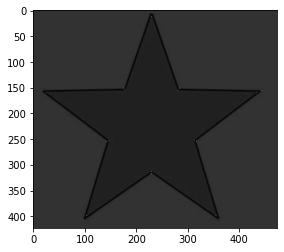

In [6]:
plt.imshow(copy_img, cmap="gray")

In [7]:
def calc_r(i, j):
    cell_x = conv_img_x[i-1:i+2, j-1:j+2]
    cell_y = conv_img_y[i-1:i+2, j-1:j+2]
    cell_x_sqr = np.square(cell_x) * gaussian_template
    cell_y_sqr = np.square(cell_y) * gaussian_template
    cell_xy_multi = cell_x * cell_y * gaussian_template
    x_sqr = np.sum(cell_x_sqr)
    y_sqr = np.sum(cell_y_sqr)
    xy_multi = np.sum(cell_xy_multi)
    mat = np.array([
        [x_sqr, xy_multi], 
        [xy_multi, y_sqr]
    ])
    val, _ = np.linalg.eig(mat)
    lam_1, lam_2 = val
    r = int(lam_1 * lam_2 - 0.04*((lam_1+lam_2)**2))
    return r, val 

In [21]:
# 通过检测R来判断是否是角点，并做非极大值抑制
visited = set()
copy_img = new_img.copy()
for i in range(1, a-1):
    for j in range(1, b-1):
        if (i, j) in visited:
            continue
        visited.add((i, j))
        r, val = calc_r(i, j)
        tem = []
        if i-1 > 0 and j-1 > 0:
            tem.append(calc_r(i-1, j-1)[0])
        if i-1 > 0 and j > 0:
            tem.append(calc_r(i-1, j)[0])
        if i-1 > 0 and j+1 < b-1:
            tem.append(calc_r(i-1, j+1)[0])
        if i > 0 and j-1 > 0:
            tem.append(calc_r(i, j-1)[0])
        if i > 0 and j+1 < b-1:
            tem.append(calc_r(i, j+1)[0])
        if i+1 < a-1 and j-1 > 0:
            tem.append(calc_r(i+1, j)[0])
        if i+1 < a-1 and j > 0:
            tem.append(calc_r(i+1, j)[0])
        if i+1 < a-1 and j+1 < b-1:
            tem.append(calc_r(i+1, j+1)[0])
        if r >= max(tem):
            visited.add((i-1, j-1))
            visited.add((i-1, j))
            visited.add((i-1, j+1))
            visited.add((i, j-1))
            visited.add((i, j+1))
            visited.add((i+1, j-1))
            visited.add((i+1, j))
            visited.add((i+1, j+1))
        if r > 3510874:
            lam_1, lam_2 = val
            a_ = 1 / np.sqrt(lam_1)
            b_= 1 / np.sqrt(lam_2)
            for theta in np.arange(0, 2*np.pi, 0.1):
                x = int(i + a_*10*np.sin(theta))
                y = int(j + b_*10*np.cos(theta))
                copy_img[x, y] += 10

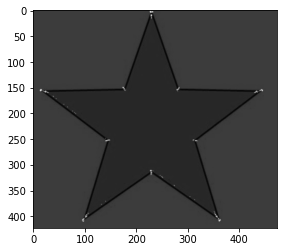

In [22]:
plt.imshow(copy_img, cmap="gray")